# Solar Power Generation – MLP (Neural Network) Regression Model

## Objective

The objective of this notebook is to build and evaluate a **Multi-Layer Perceptron (MLP) Regressor** to predict **`power_generated`** (energy produced in Joules during each 3-hour interval) from environmental variables.

MLP is a feedforward neural network that:
- Can model complex non-linear relationships between features and the target.
- Requires careful scaling, regularization, and tuning of architecture (hidden layers), activation, and learning rate.

### Input features
- `distance_to_solar_noon`
- `temperature`
- `wind_direction`
- `wind_speed`
- `sky_cover`
- `visibility`
- `humidity`
- `average_wind_speed_period`
- `average_pressure_period`

### Notebook workflow
1. Load and inspect the dataset  
2. Handle missing values  
3. Rename columns for safety (if needed)  
4. Define features (`X`) and target (`y`)  
5. Train–test split  
6. Build an MLP pipeline (scaling + MLP)  
7. Hyperparameter tuning with GridSearchCV  
8. Evaluate model (MAE, RMSE, R²)  
9. Visualize Actual vs Predicted  
10. Save the trained model


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib


## 1. Load the Dataset

We load the original solar power generation dataset from the CSV file.  
This dataset contains 2920 rows (instances) and 10 columns (variables).


In [4]:
data_path = r"D:\DATA-SCIENCE\project\solarpowergeneration.csv"

df = pd.read_csv(data_path)

df.head()


,distance-to-solar-noon,temperature,wind-direction,wind-speed,sky-cover,visibility,humidity,average-wind-speed-(period),average-pressure-(period),power-generated
0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


## 2. Basic Dataset Overview

We inspect the dataset structure, including:

- Number of rows and columns  
- Column names and data types  
- Presence of missing values  

This helps us understand data quality before preprocessing.


In [5]:
print("Shape of the dataset:", df.shape)
print("\nColumn information:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())


Shape of the dataset: (2920, 10)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   distance-to-solar-noon       2920 non-null   float64
 1   temperature                  2920 non-null   int64  
 2   wind-direction               2920 non-null   int64  
 3   wind-speed                   2920 non-null   float64
 4   sky-cover                    2920 non-null   int64  
 5   visibility                   2920 non-null   float64
 6   humidity                     2920 non-null   int64  
 7   average-wind-speed-(period)  2919 non-null   float64
 8   average-pressure-(period)    2920 non-null   float64
 9   power-generated              2920 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 228.3 KB
None

Missing values per column:
distance-to-solar-noon         0
temperature              

## 3. Handling Missing Values

From the dataset overview, we found **1 missing value** in the column  
`average-wind-speed-(period)`.

Since this is a numeric column, we replace the missing value with the **median**, which is robust to outliers and preserves the data distribution.


In [6]:
# Impute the single missing value in average-wind-speed-(period)
df["average-wind-speed-(period)"] = df["average-wind-speed-(period)"].fillna(
    df["average-wind-speed-(period)"].median()
)

print("Missing values after imputation:")
print(df.isna().sum())


Missing values after imputation:
distance-to-solar-noon         0
temperature                    0
wind-direction                 0
wind-speed                     0
sky-cover                      0
visibility                     0
humidity                       0
average-wind-speed-(period)    0
average-pressure-(period)      0
power-generated                0
dtype: int64


## 4. Rename Columns

To ensure compatibility with scikit-learn and avoid issues with special characters,
we rename columns by replacing:

- Hyphens (`-`) → underscores  
- Parentheses `(` and `)` → removed  

This creates clean and consistent feature names.


In [7]:
df.columns = (
    df.columns
    .str.replace("-", "_")
    .str.replace("(", "")
    .str.replace(")", "")
)

df.head()


,distance_to_solar_noon,temperature,wind_direction,wind_speed,sky_cover,visibility,humidity,average_wind_speed_period,average_pressure_period,power_generated
0,0.859897,69,28,7.5,0,10.0,75,8.0,29.82,0
1,0.628535,69,28,7.5,0,10.0,77,5.0,29.85,0
2,0.397172,69,28,7.5,0,10.0,70,0.0,29.89,5418
3,0.165810,69,28,7.5,0,10.0,33,0.0,29.91,25477
4,0.065553,69,28,7.5,0,10.0,21,3.0,29.89,30069


## 5. Define Features (X) and Target (y)

The target variable is:

- `power_generated`: energy produced in Joules for each 3-hour interval.

All other variables are used as predictors. We separate the dataset into:

- `X`: feature matrix (independent variables)  
- `y`: target vector (dependent variable)


In [8]:
target_col = "power_generated"

X = df.drop(columns=[target_col])
y = df[target_col]

X.shape, y.shape


((2920, 9), (2920,))

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## 6. Build MLP Regressor Pipeline

Neural networks are sensitive to feature scales, so we:

1. Standardize features using **StandardScaler**  
2. Train an **MLPRegressor** with one or more hidden layers  

We enable early stopping to reduce overfitting.


In [9]:
mlp_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", MLPRegressor(
        hidden_layer_sizes=(128, 64),   # two-layer MLP
        activation="relu",
        learning_rate_init=0.001,
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    ))
])

mlp_pipeline


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,loss,'squared_error'
,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'


In [13]:
# Train the model
mlp_pipeline.fit(X_train, y_train)

# Predictions
y_pred = mlp_pipeline.predict(X_test)

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MLP Regressor Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")


MLP Regressor Performance:
RMSE: 3975.8755
MAE : 1968.4235
R²  : 0.8499


## 7. Hyperparameter Tuning for MLP

We tune the following hyperparameters:

- `hidden_layer_sizes`: architecture of the hidden layers  
- `activation`: activation function for hidden layers  
- `alpha`: L2 regularization parameter  
- `learning_rate_init`: initial learning rate

We use **GridSearchCV** to search over a set of reasonable values.


In [14]:
param_grid = {
    "model__hidden_layer_sizes": [(64, 32), (128, 64), (64, 64, 32)],
    "model__activation": ["relu", "tanh"],
    "model__alpha": [0.0001, 0.001, 0.01],
    "model__learning_rate_init": [0.001, 0.01]
}

grid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (negative MSE):", grid_search.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (128, 64), 'model__learning_rate_init': 0.01}
Best CV score (negative MSE): -15038580.827020874



## 8. Evaluate the Tuned MLP Regressor on the Test Set

After identifying the best hyperparameters using GridSearchCV, we evaluate the optimized MLP Regressor on the test set. This step verifies how well the tuned model generalizes to unseen data.

We generate predictions using the best estimator returned by the grid search and compute key regression metrics:

* **MAE (Mean Absolute Error):** Measures average absolute deviation between actual and predicted values.
* **RMSE (Root Mean Squared Error):** Penalizes larger errors more strongly and reflects overall prediction accuracy.
* **R² Score:** Indicates how much variance in the target variable is explained by the model.

These metrics help us understand whether hyperparameter tuning improved performance compared to the initial MLP model.




In [16]:
best_mlp = grid_search.best_estimator_

y_pred = best_mlp.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MLP Regressor Performance on Test Set")
print("-------------------------------------")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


MLP Regressor Performance on Test Set
-------------------------------------
MAE  : 1886.0729
RMSE : 3872.8450
R²   : 0.8576


9. Actual vs Predicted Plot for MLP Regressor

To visually assess the performance of the tuned MLP Regressor, we create a scatter plot comparing the actual power generation values against the model’s predictions.

Each point represents a test sample:

Points close to the diagonal dashed line indicate accurate predictions.

Points far from the line represent larger errors.

This visualization helps reveal patterns such as underfitting, overfitting, or areas where the model struggles—especially in low-power or highly variable regions.

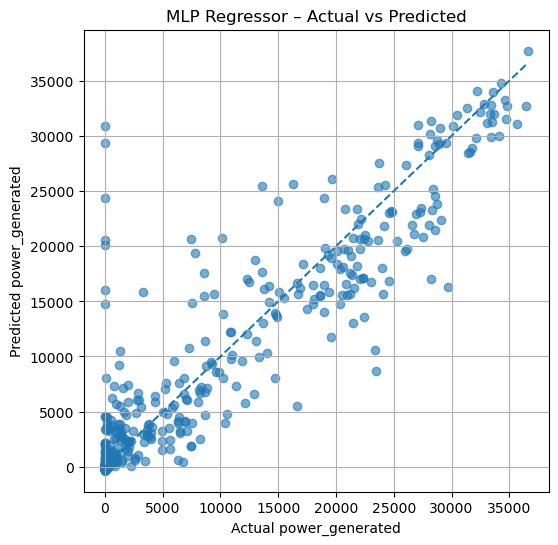

In [17]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("Actual power_generated")
plt.ylabel("Predicted power_generated")
plt.title("MLP Regressor – Actual vs Predicted")
plt.grid(True)
plt.show()


10. Save the Final MLP Model

After training and tuning the MLP Regressor, we save the best-performing model to disk.
The entire pipeline—including preprocessing (StandardScaler) and the trained neural network—is stored using joblib, allowing the model to be loaded later without retraining.

Saving the model ensures reproducibility and makes it easy to use the trained pipeline for future predictions or deployment.

In [18]:
model_path = r"D:\DATA-SCIENCE\project\mlp_model.pkl"
joblib.dump(best_mlp, model_path)

print(f"Model saved to: {model_path}")


Model saved to: D:\DATA-SCIENCE\project\mlp_model.pkl
